In [1]:
import json
import random
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import spacy
from spacy.scorer import Scorer
from spacy.training.example import Example
from spacy.util import minibatch

In [2]:
def load_spacy_data(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    tupled_data = []
    for entry in data:
        entities = [tuple(ent) for ent in entry[1]["entities"]]
        tupled_data.append((entry[0], {"entities": entities}))
    return tupled_data

train_data = load_spacy_data("../res/data/dataset/themodders_forum_monster_sentences/monster_big_no_overlap_train.json")
test_data = load_spacy_data("../res/data/dataset/themodders_forum_monster_sentences/monster_big_no_overlap_test.json")

In [3]:
nlp = spacy.load('pl_core_news_md')

if 'ner' not in nlp.pipe_names:
    ner = nlp.add_pipe('ner')
else:
    ner = nlp.get_pipe('ner')

# Add any labels that appear in the annotations
for _, annotations in train_data:
    for ent in annotations['entities']:
        if ent[2] not in ner.labels:
            ner.add_label(ent[2])

In [5]:
evaluation_data = []
best_f1 = 0
best_epoch = 0
best_model_path = "gmonsters_ner_best_f1"

other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()

    epochs = 60
    for epoch in range(1, epochs + 1):
        random.shuffle(train_data)
        losses = {}
        batches = minibatch(train_data, size=64)

        # train
        for batch in batches:
            train_examples = []
            for text, annotations in batch:
                doc = nlp.make_doc(text)
                train_example = Example.from_dict(doc, annotations)
                train_examples.append(train_example)
            nlp.update(train_examples, drop=0.5, losses=losses)

        # test
        test_examples = []
        scorer = Scorer()
        for text, annotations in test_data:
            doc = nlp.make_doc(text)
            test_example = Example.from_dict(doc, annotations)
            test_example.predicted = nlp(str(test_example.predicted))
            test_examples.append(test_example)
        scores = scorer.score(test_examples)

        epoch_data = {
            "epoch": epoch,
            "losses": float(losses["ner"]),
            "Precision": scores["ents_p"],
            "Recall": scores["ents_r"],
            "F1-score": scores["ents_f"]
        }
        evaluation_data.append(epoch_data)

        # Save best model only
        if scores["ents_f"] > best_f1:
            best_f1 = scores["ents_f"]
            best_epoch = epoch
            if os.path.exists(best_model_path):
                shutil.rmtree(best_model_path)
            nlp.to_disk(best_model_path)

        if epoch % 10 == 0:
            print(f"Epoch {epoch} finished training")

print(f"Saved epoch {best_epoch} with f1 = {best_f1}")

/opt/homebrew/Caskroom/miniconda/base/envs/custom_ner/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "CONST INT GIL_ORCSLAVE                           =..." with entities "[(77, 80, 'MONSTER')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/custom_ner/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Nie chcę tutaj umniejszać zasług @Młodego ścierwoj..." with entities "[(34, 53, 'MONSTER')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/custom_ner/lib/python3.12/site-packages/spacy/training/

Epoch 10 finished training
Epoch 20 finished training
Epoch 30 finished training
Epoch 40 finished training
Epoch 50 finished training
Epoch 60 finished training
Saved epoch 52 with f1 = 0.9137931034482759


 epoch       losses  Precision   Recall  F1-score
     1 23151.208984   0.000000 0.000000  0.000000
     2  3203.161865   0.000000 0.000000  0.000000
     3  2855.864258   0.000000 0.000000  0.000000
     4  2485.601562   0.654412 0.514451  0.576052
     5  1999.515015   0.538153 0.774566  0.635071
     6  1699.811157   0.661836 0.791908  0.721053
     7  1475.286011   0.566265 0.815029  0.668246
     8  1277.702515   0.624454 0.826590  0.711443
     9  1199.494629   0.699507 0.820809  0.755319
    10   916.295837   0.708738 0.843931  0.770449
    11   765.440186   0.762887 0.855491  0.806540
    12   616.257324   0.742424 0.849711  0.792453
    13   565.741211   0.785714 0.890173  0.834688
    14   479.557556   0.837838 0.895954  0.865922
    15   504.552124   0.829787 0.901734  0.864266
    16   373.698608   0.816754 0.901734  0.857143
    17   332.495819   0.820106 0.895954  0.856354
    18   286.396912   0.853261 0.907514  0.879552
    19   278.682861   0.867403 0.907514  0.887006


<Axes: >

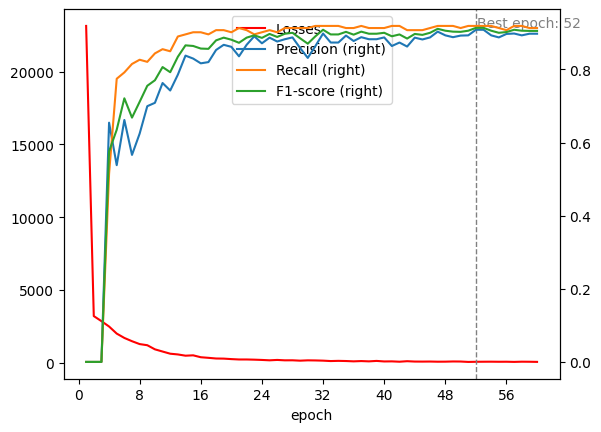

In [6]:
df = pd.DataFrame.from_dict(evaluation_data)

print(df.to_string(index=False))

ax = df.plot(x='epoch', y='losses', kind='line', color='red', label='Losses')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.axvline(x=best_epoch, color='gray', linestyle='--', linewidth=1)
ax.text(best_epoch + 0.2, ax.get_ylim()[1]*0.95, f'Best epoch: {best_epoch}', color='gray')
df.plot(x='epoch', y=['Precision', 'Recall', 'F1-score'], kind='line', ax=ax, secondary_y=True)

## Final manual check

In [7]:
nlp = spacy.load("gmonsters_ner_best")

In [17]:
texts = [
    "Polne gobliny",  # novel monster
    "Uciekał jakby goniło go stado baranów",  # exact wordform 'baranów' not present in the dataset
    "Trzeba zabić paru orków szamanów",
    "Trzeba zabić paru orków-szamanów",
    "Na drodze do świątyni stoi jeden ork wojownik",
    "Z chrząszcza potrawka",
    "Z chrzaszcza potrawka",  # no diacritics (not annotated in dataset)
    "Ścierwojady – tak nazywamy te wielkie ptaszyska – należy atakować jeden po drugim.",
    "Scierwojady – tak nazywamy te wielkie ptaszyska – należy atakować jeden po drugim.", # no diacritics (not annotated in dataset)
    "Ściewrojady – tak nazywamy te wielkie ptaszyska – należy atakować jeden po drugim.", # typo (not annotated in dataset)
    "Skóra z orkowego psa",
    "Skóra z orkoewgo psa",  # typo (not annotated in dataset)
    "Gonił mnie jakiś straszny pies"  # negative example
]

for text in texts:
    doc = nlp(text)
    print(f'Text: {text}')
    print('Entities', [(ent.text, ent.label_) for ent in doc.ents])

Text: Polne gobliny
Entities [('Polne gobliny', 'MONSTER')]
Text: Uciekał jakby goniło go stado baranów
Entities [('baranów', 'MONSTER')]
Text: Trzeba zabić paru orków szamanów
Entities [('orków szamanów', 'MONSTER')]
Text: Trzeba zabić paru orków-szamanów
Entities [('orków', 'MONSTER'), ('szamanów', 'MONSTER')]
Text: Na drodze do świątyni stoi jeden ork wojownik
Entities [('ork wojownik', 'MONSTER')]
Text: Z chrząszcza potrawka
Entities [('chrząszcza', 'MONSTER')]
Text: Z chrzaszcza potrawka
Entities [('chrzaszcza', 'MONSTER')]
Text: Ścierwojady – tak nazywamy te wielkie ptaszyska – należy atakować jeden po drugim.
Entities [('Ścierwojady', 'MONSTER')]
Text: Scierwojady – tak nazywamy te wielkie ptaszyska – należy atakować jeden po drugim.
Entities []
Text: Ściewrojady – tak nazywamy te wielkie ptaszyska – należy atakować jeden po drugim.
Entities []
Text: Skóra z orkowego psa
Entities [('orkowego psa', 'MONSTER')]
Text: Skóra z orkoewgo psa
Entities [('orkoewgo psa', 'MONSTER')]
Text